## 개선된 U-Net 모델 만들기

2018년도에 U-Net++ 라는 논문이 나옴.

- U-Net++:v1
  - https://arxiv.org/abs/1807.10165 참고
- U-Net++:v2
  - https://arxiv.org/abs/1912.05074 참고
- 관련 코드
  - https://github.com/MrGiovanni/UNetPlusPlus 참고
  - 코드 중 up_block으로는 두 가지 방식을 사용
    - Transpose2D_block 또는 Upsample2D_block
    - 둘 중 어느 것을 사용해도 좋음
  - 또 한 가지 주의해야 할 점은 Loss를 조금 다르게 구현해야 한다는 점
    - binary cross-entropy 와 dice coefficient 를 사용

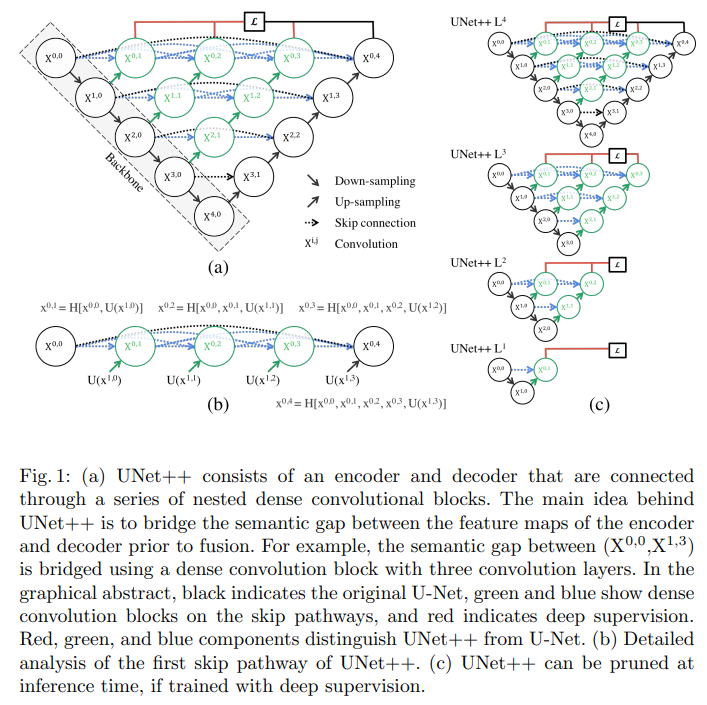

In [1]:
from IPython.display import Image
Image(filename='capture/u-net++.png') 

### GPU 지정

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="6"

### 라이브러리 로딩

In [2]:
import tensorflow as tf
import numpy as np
import PIL
import skimage
import albumentations

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

2.9.2
1.21.6
8.0.0
0.16.2
1.2.1


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 필요한 함수들 로딩

In [4]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

%matplotlib inline

In [5]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

In [6]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

### KITTI 데이터셋 수집과 구축

In [7]:
dir_path = '../dl_data/kitti_semantics/training'

augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

### U-Net 모델 구현

In [8]:
def build_unet(input_shape=(224, 224, 3)):
    model = None
    # TODO: input_shape에 따라 U-Net을 만들어주세요
    # 이때 model은 fully convolutional해야 합니다.

    inputs = Input(input_shape)

    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
    
    #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [9]:
unet_path = './checkpoints/semantic_segmentation/seg_model_unet.h5'

unet = build_unet()
unet.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
unet.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=10,
 )

unet.save(unet_path)

Epoch 1/10
11/11 [==============================] - 9s 231ms/step - loss: 0.6929 - val_loss: 0.6926
Epoch 2/10
11/11 [==============================] - 2s 192ms/step - loss: 0.6924 - val_loss: 0.6921
Epoch 3/10
11/11 [==============================] - 2s 192ms/step - loss: 0.6918 - val_loss: 0.6916
Epoch 4/10
11/11 [==============================] - 2s 191ms/step - loss: 0.6913 - val_loss: 0.6910
Epoch 5/10
11/11 [==============================] - 2s 208ms/step - loss: 0.6908 - val_loss: 0.6905
Epoch 6/10
11/11 [==============================] - 2s 192ms/step - loss: 0.6902 - val_loss: 0.6900
Epoch 7/10
11/11 [==============================] - 2s 192ms/step - loss: 0.6897 - val_loss: 0.6894
Epoch 8/10
11/11 [==============================] - 2s 193ms/step - loss: 0.6892 - val_loss: 0.6889
Epoch 9/10
11/11 [==============================] - 2s 192ms/step - loss: 0.6886 - val_loss: 0.6884
Epoch 10/10
11/11 [==============================] - 2s 203ms/step - loss: 0.6881 - val_loss: 0.6879

### U-Net++ 모델 구현

In [10]:
def build_unet_pp(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)

  # X(0,0)
  conv0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_0_conv1')(inputs)
  conv0_0 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_0_conv2')(conv0_0)
  
  # X(1,0)
  pool1_0 = MaxPooling2D(pool_size=(2, 2), name='X_1_0_pool')(conv0_0)
  conv1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_1_0_conv1')(pool1_0)
  conv1_0 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_1_0_conv2')(conv1_0)
  
  # X(0,1)
  up0_1 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal',name='X_0_1_up')(conv1_0)
  merge0_1 = concatenate([conv0_0,up0_1], axis = 3, name='X_0_1_merge')
  conv0_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_1_conv1')(merge0_1)
  conv0_1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_1_conv2')(conv0_1)

  # X(2,0)
  pool2_0 = MaxPooling2D(pool_size=(2, 2), name='X_2_0_pool')(conv1_0)
  conv2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_2_0_conv1')(pool2_0)
  conv2_0 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_2_0_conv2')(conv2_0)

  # X(1,1)
  up1_1 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal',name='X_1_1_up')(conv2_0)
  merge1_1 = concatenate([conv1_0,up1_1], axis = 3, name='X_1_1_merge')
  conv1_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_1_1_conv1')(merge1_1)
  conv1_1 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_1_1_conv2')(conv1_1)

  # X(0,2)
  up0_2 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal',name='X_0_2_up')(conv1_1)
  merge0_2 = concatenate([conv0_0,conv0_1,up0_2], axis = 3, name='X_0_2_merge')
  conv0_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_2_conv1')(merge0_2)
  conv0_2 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_2_conv2')(conv0_2)

  # X(3,0)
  pool3_0 = MaxPooling2D(pool_size=(2, 2), name='X_3_0_pool')(conv2_0)
  conv3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_3_0_conv1')(pool3_0)
  conv3_0 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_3_0_conv2')(conv3_0)
  drop3_0 = Dropout(0.5, name='X_3_0_DO')(conv3_0)

  # X(2,1)
  up2_1 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal',name='X_2_1_up')(conv3_0)
  merge2_1 = concatenate([conv2_0,up2_1], axis = 3, name='X_2_1_merge')
  conv2_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_2_1_conv1')(merge2_1)
  conv2_1 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_2_1_conv2')(conv2_1)

  # X(1,2)
  up1_2 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal',name='X_1_2_up')(conv2_1)
  merge1_2 = concatenate([conv1_0,conv1_1,up1_2], axis = 3, name='X_1_2_merge')
  conv1_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_1_2_conv1')(merge1_2)
  conv1_2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_1_2_conv2')(conv1_2)

  # X(0,3)
  up0_3 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal',name='X_0_3_up')(conv1_2)
  merge0_3 = concatenate([conv0_0,conv0_1,conv0_2,up0_3], axis = 3, name='X_0_3_merge')
  conv0_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_3_conv1')(merge0_3)
  conv0_3 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_3_conv2')(conv0_3)

  # X(4,0)
  pool4_0 = MaxPooling2D(pool_size=(2, 2), name='X_4_0_pool')(drop3_0)
  conv4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_4_0_conv1')(pool4_0)  
  conv4_0 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_4_0_conv2')(conv4_0)
  drop4_0 = Dropout(0.5, name='X_4_0_DO')(conv4_0)

  # X(3,1)
  up3_1 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal', name='X_3_1_up')(drop4_0)
  merge3_1 = concatenate([drop3_0,up3_1], axis = 3, name='X_3_1_merge')
  conv3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_3_1_conv1')(merge3_1)
  conv3_1 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_3_1_conv2')(conv3_1)

  # X(2,2)
  up2_2 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal', name='X_2_2_up')(conv3_1)
  merge2_2 = concatenate([conv2_0,conv2_1,up2_2], axis = 3, name='X_2_2_merge')
  conv2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_2_2_conv1')(merge2_2)
  conv2_2 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_2_2_conv2')(conv2_2)

  # X(1,3)
  up1_3 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal', name='X_1_3_up')(conv2_2)
  merge1_3 = concatenate([conv1_0,conv1_1,conv1_2,up1_3], axis = 3, name='X_1_3_merge')
  conv1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_1_3_conv1')(merge1_3)
  conv1_3 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_1_3_conv2')(conv1_3)

  # X(0,4)
  up0_4 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal',name='X_0_4_up')(conv1_3)
  merge0_4 = concatenate([conv0_0,conv0_1,conv0_2,conv0_3,up0_4], axis = 3, name='X_0_4_merge')
  conv0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_4_conv1')(merge0_4)
  conv0_4 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_4_conv2')(conv0_4)  
  conv0_4 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal', name='X_0_4_conv3')(conv0_4)     

  outputs = Conv2D(1, 1, activation='sigmoid', name='output')(conv0_4)

  model = Model(inputs = inputs, outputs = outputs)
  return model

In [12]:
unet_pp_path = './checkpoints/semantic_segmentation/seg_model_unet_pp.h5'

unet_pp = build_unet_pp()
unet_pp.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
unet_pp.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
 )

unet_pp.save(unet_pp_path)

Epoch 1/10
11/11 [==============================] - 9s 539ms/step - loss: 0.6869 - val_loss: 0.6733
Epoch 2/10
11/11 [==============================] - 5s 480ms/step - loss: 0.6238 - val_loss: 0.4198
Epoch 3/10
11/11 [==============================] - 5s 481ms/step - loss: 0.0850 - val_loss: 0.0312
Epoch 4/10
11/11 [==============================] - 5s 482ms/step - loss: 0.0360 - val_loss: 0.0318
Epoch 5/10
11/11 [==============================] - 5s 485ms/step - loss: 0.0328 - val_loss: 0.0346
Epoch 6/10
11/11 [==============================] - 5s 484ms/step - loss: 0.0365 - val_loss: 0.0379
Epoch 7/10
11/11 [==============================] - 5s 482ms/step - loss: 0.0317 - val_loss: 0.0277
Epoch 8/10
11/11 [==============================] - 5s 480ms/step - loss: 0.0258 - val_loss: 0.0265
Epoch 9/10
11/11 [==============================] - 5s 480ms/step - loss: 0.0249 - val_loss: 0.0252
Epoch 10/10
11/11 [==============================] - 5s 486ms/step - loss: 0.0259 - val_loss: 0.0267

### 결과 분석

In [13]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [18]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

#### U-Net 의 결과

In [19]:
unet = tf.keras.models.load_model(unet_path)

# index의 값을 바꾸면 테스트용 이미지도 달라집니다.
index = 0

for i in range(index, index+5):
    output, prediction, target = get_output(
     unet, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
    )

    calculate_iou_score(target, prediction)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
IoU : 0.000000
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
IoU : 0.000000
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
IoU : 0.000000
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
IoU : 0.000000
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
IoU : 0.000000


#### U-Net++ 의 결과

In [16]:
unet_pp = tf.keras.models.load_model(unet_pp_path)

# index의 값을 바꾸면 테스트용 이미지도 달라집니다.
index = 0

for i in range(index, index+5):
    output, prediction, target = get_output(
     unet_pp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
    )

    calculate_iou_score(target, prediction)

IoU : 0.000000
IoU : 0.000000
IoU : 0.000000
IoU : 0.000000
IoU : 0.000000
